In [102]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image
import matplotlib.pyplot as plt

import plotly.plotly as py
import plotly.graph_objs as go

import re
import csv
import scipy.ndimage
from scipy.stats import norm
from scipy.stats import gaussian_kde

from spindle_tracker.io.trackmate import trackmate_peak_import
from spindle_tracker.io import TiffFile

In [4]:
os.chdir ("G:/20170404/1804_2/X0_Y0_MITOSIS/")
list_detected_mitosis =  os.listdir("croppedImgs")

In [8]:
for cell in list_detected_mitosis : 
    print ("Cellule en analyse : " + cell)
    
    # Definir si la cellule est en mitose ou non
    cellule_en_mitose =  input("Est-ce une mitose? ('o' ou 'n') :\t")
    while cellule_en_mitose!='o' and cellule_en_mitose!='n' :
        cellule_en_mitose = input("Vous pouvez repeter la reponse!!! \n Est-ce une mitose? ('o' ou 'n'): \t")                
    if cellule_en_mitose == 'n':
        print ("C'est la loose")
    else :
        print ("Youpie c'est une mitose!!! <3")
        
        """Ouverture du crop"""
        crop = TiffFile(+cell[:-4]+".tif")
        arr = crop.asarray()
        arr = np.squeeze(arr)
        #log.info("Convert tiff to 8bit")
        arr = np.round(255.0 * (arr - arr.min()) / (arr.max() - arr.min() - 1.0)).astype(np.uint8)
        
        # Perform maximum projection on second axis
        # Structure du crop_projection
        # [a,y,x], avec 'a' le numero de la frame
        crop_projection = arr.max(axis=1)
        
        
        
        # Recuperation des positions des SPBs
        spotsPath = "spots/"+cell[:-4]+".xml"
        if os.path.lexists(spotsPath):
            gfpSpots = trackmate_peak_import(spotsPath,False)
            
        
        for num_frame in gfpSpots.index.levels[0]:
            current_frame_poles = gfpSpots.loc[x]
            if len(current_frame_poles)>1:
                
                """
                Recuperation des coordonnees des poles
                
                current_frame_poles['x'].iloc[0]
                current_frame_poles['x'].iloc[1]
                current_frame_poles['y'].iloc[0]
                current_frame_poles['y'].iloc[1]
                """
                # Extract line 
                # Conversion en pixel necessaire ?????
                x0 = current_frame_poles['x'].iloc[0]
                y0 = current_frame_poles['x'].iloc[1]
                x1 = current_frame_poles['y'].iloc[0]
                y1 = current_frame_poles['y'].iloc[1]
                
                x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
                
                # Extract the values along the line, using cubic interpolation
                zi = scipy.ndimage.map_coordinates(crop_projection[num_frame], np.vstack((x,y)))
                
                fig, axes = plt.subplots(nrows=2)
                axes[0].imshow(crop_projection[num_frame])
                axes[0].plot([x0, x1], [y0, y1], 'ro-')
                axes[0].axis('image')

                axes[1].plot(zi)

                plt.show()
                
#http://stackoverflow.com/questions/7878398/how-to-extract-an-arbitrary-line-of-values-from-a-numpy-array
        
                    

Cellule en analyse : 112_GFP.tif
Est-ce une mitose? ('o' ou 'n') :	o
Youpie c'est une mitose!!! <3


AttributeError: 'NoneType' object has no attribute 'find'

In [15]:
os.chdir("G:/20170404/1804_2/X0_Y0_MITOSIS/croppedImgs/")
img = Image.open("60_GFP.tif")
imgarray = np.array(img)


array([149, 142, 175, 163, 168, 145, 161, 148, 169, 159, 154, 149, 157,
       153, 171, 172, 161, 161, 157, 167, 154, 139, 170, 149, 156, 170,
       169, 168, 184, 165, 155, 154, 172, 190, 165, 166, 190, 177, 189,
       180, 187, 194, 223, 216, 190, 196, 199, 162, 184, 176, 175, 163,
       193, 174, 181, 149, 175, 177, 171, 173, 157, 152, 169, 164, 162,
       150, 160, 186, 166, 171, 165, 151, 153, 165, 172, 173, 182, 163,
       159, 177, 180, 184, 178, 170], dtype=uint16)

In [91]:
arr.shape


(210, 110, 84)

In [101]:
time_max_digits_minute

2

In [ ]:
list_file = os.listdir()
for file in list_file : 
    img = Image.open(file)
    imgarray = np.array(img)
    print (file)

0


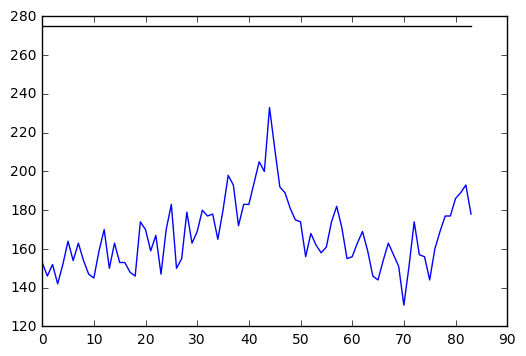

1


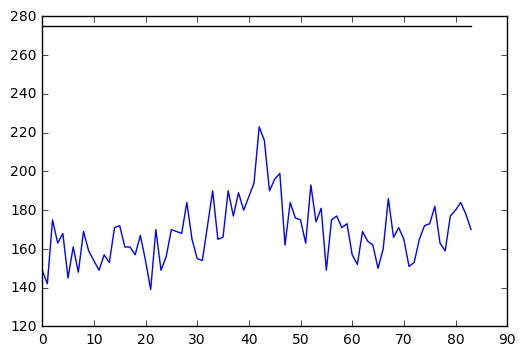

2


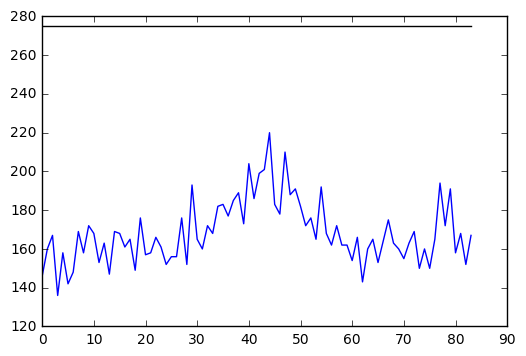

3


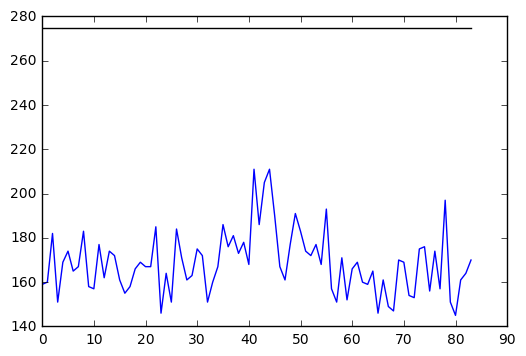

4


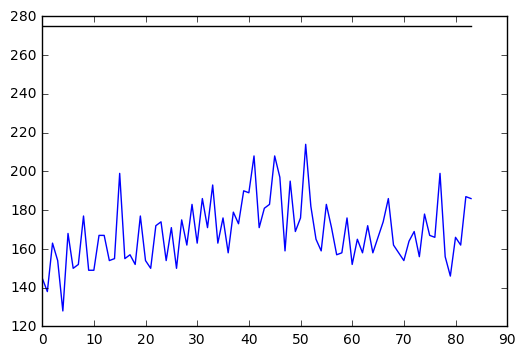

5


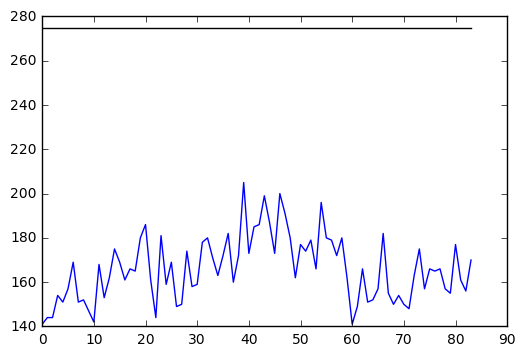

6


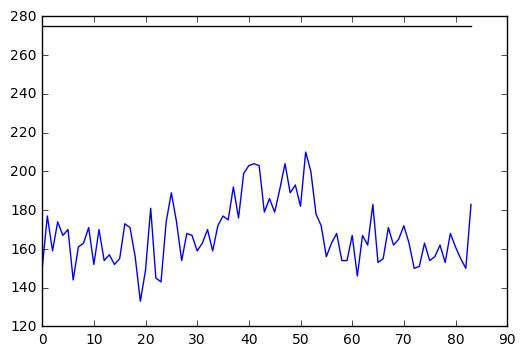

7


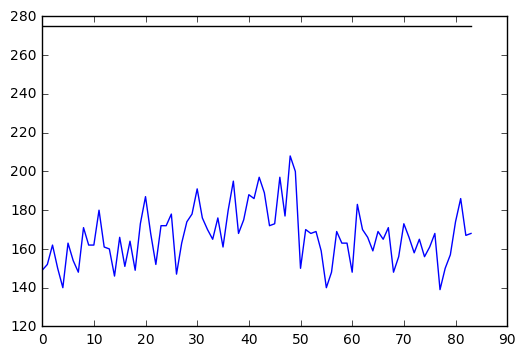

8


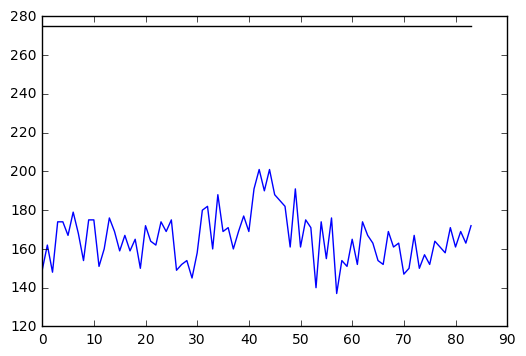

9


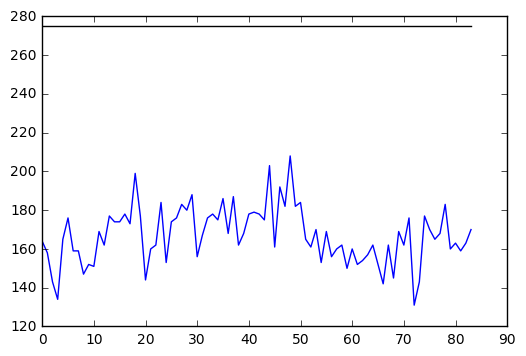

10


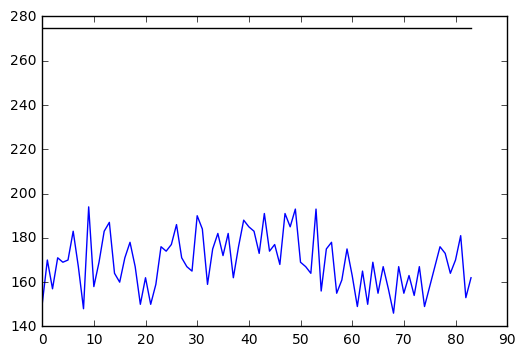

11


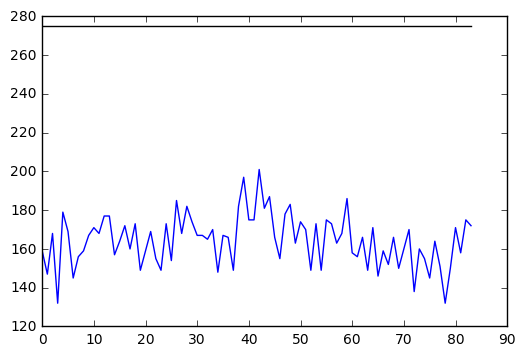

12


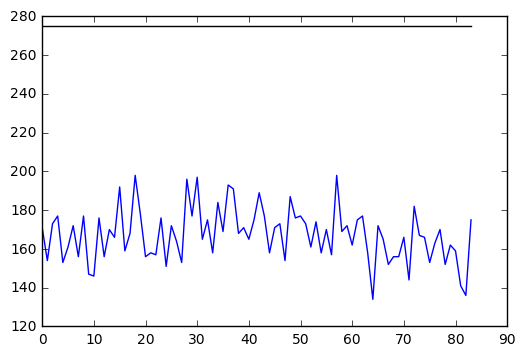

13


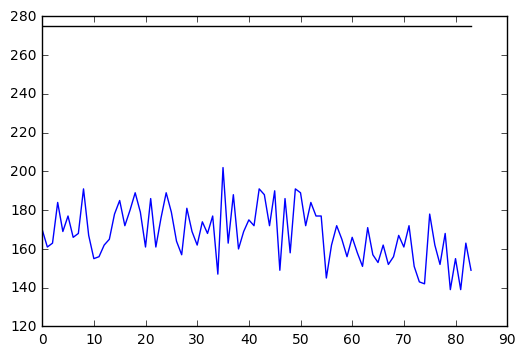

14


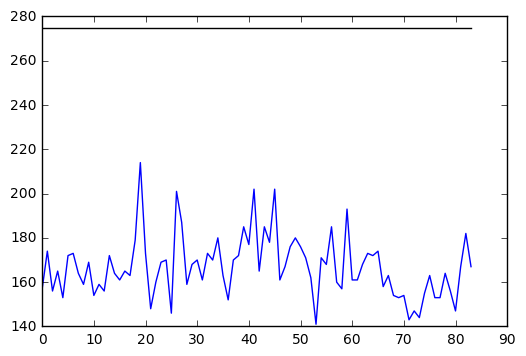

15


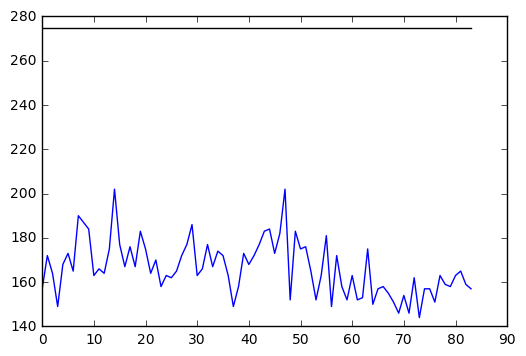

16


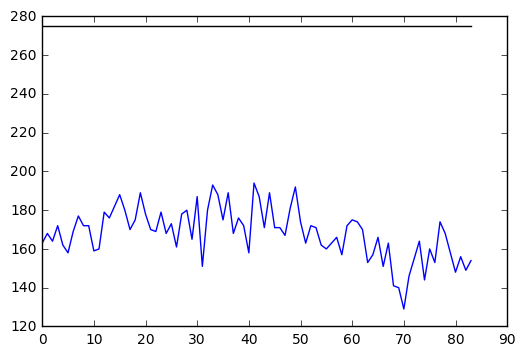

17


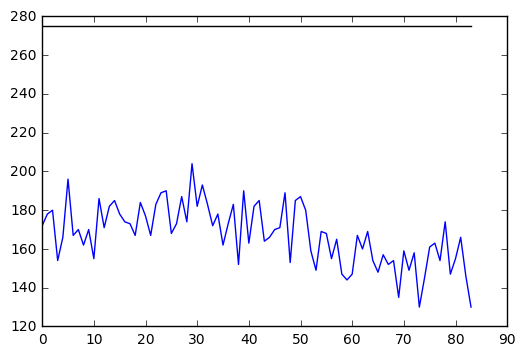

18


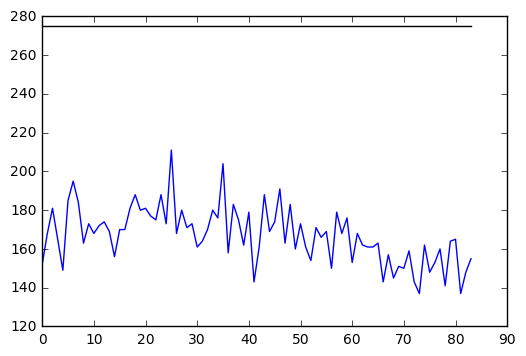

19


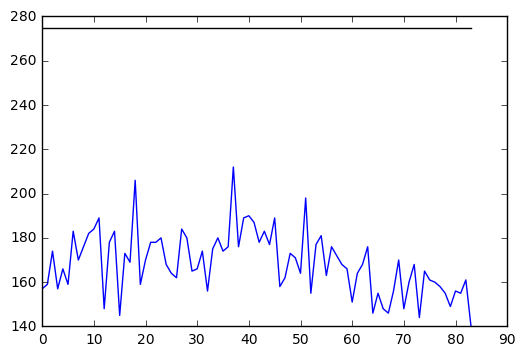

20


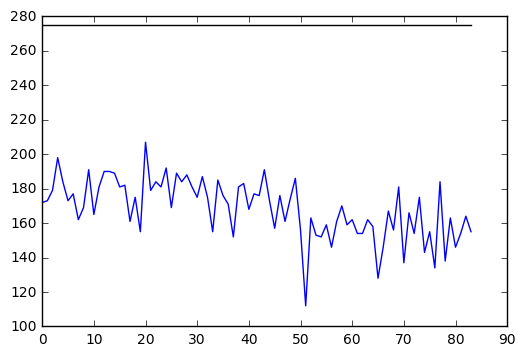

21


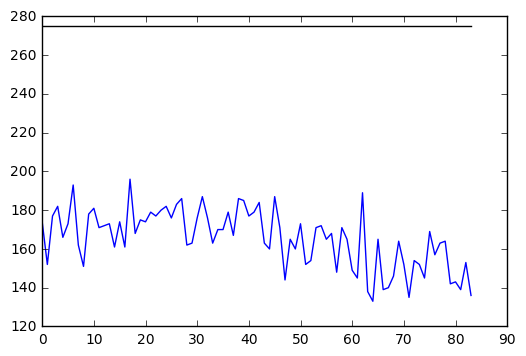

22


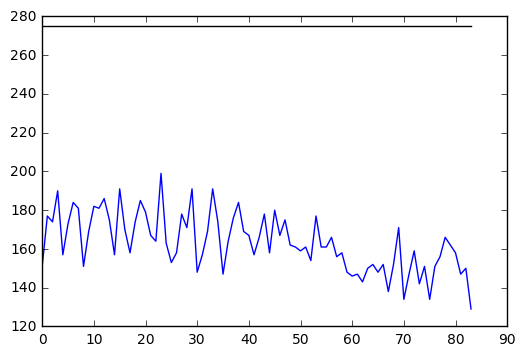

23


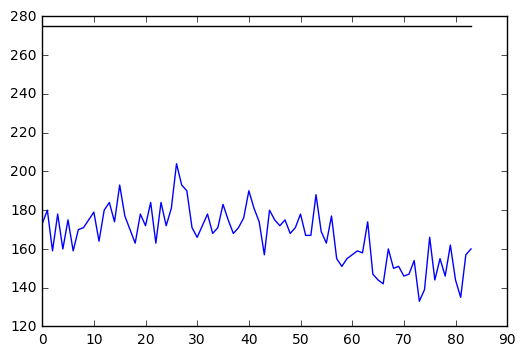

24


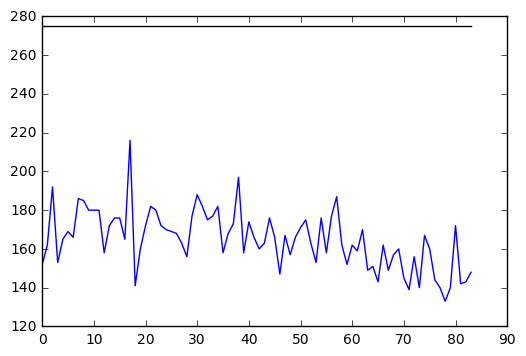

25


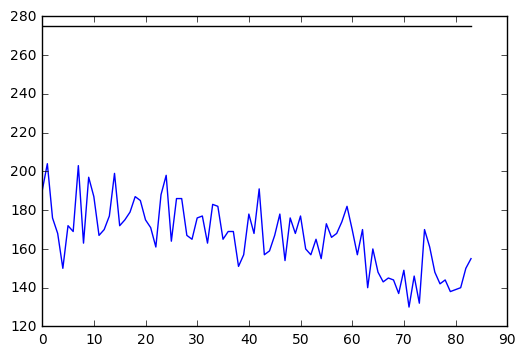

26


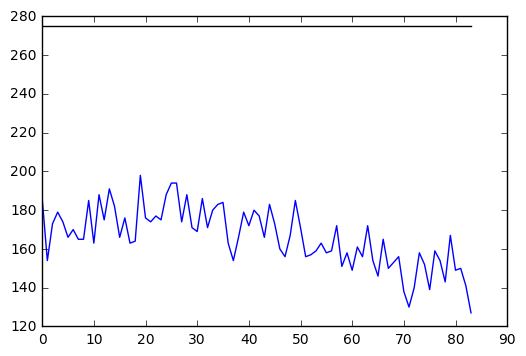

27


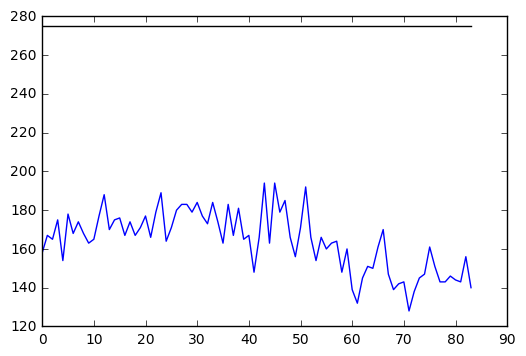

28


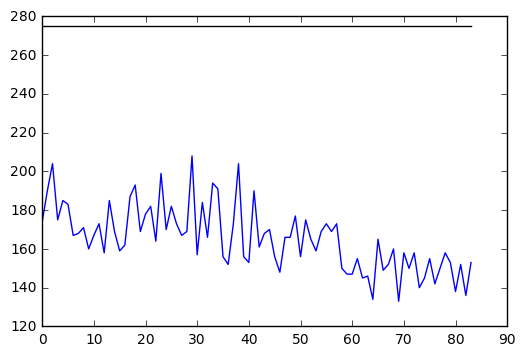

29


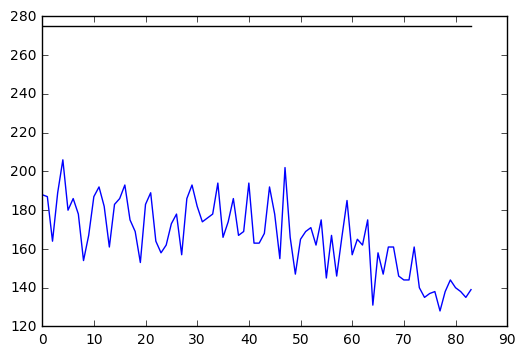

30


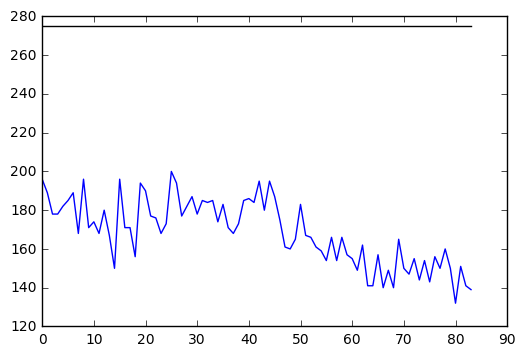

31


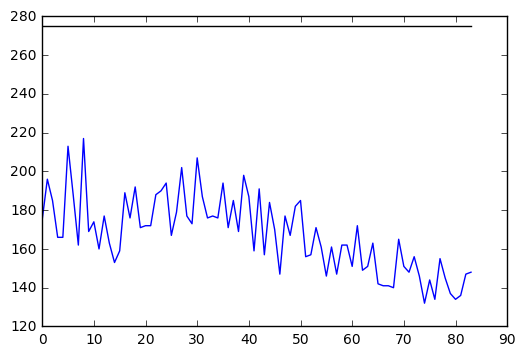

32


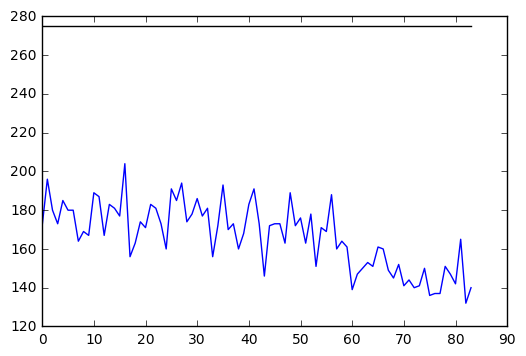

33


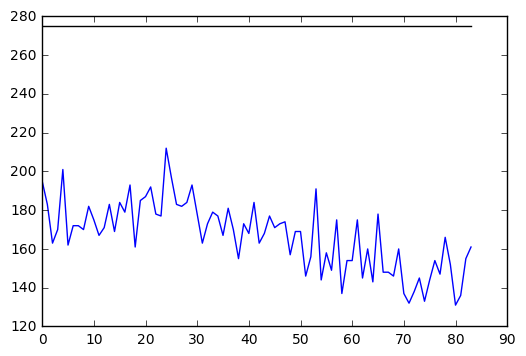

34


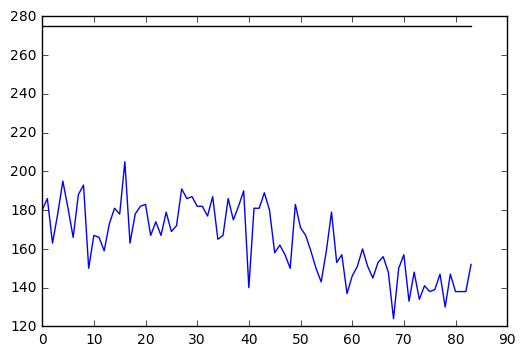

35


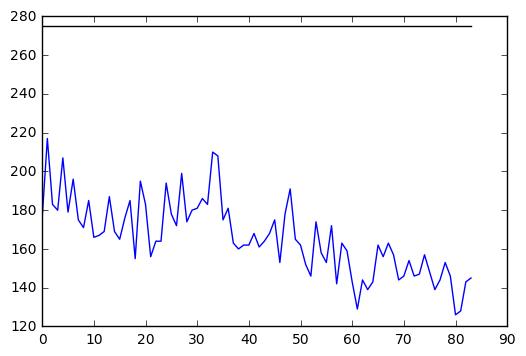

36


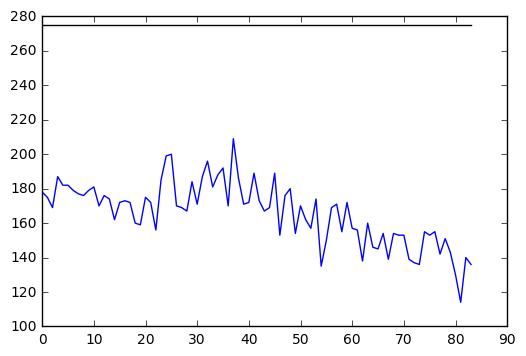

37


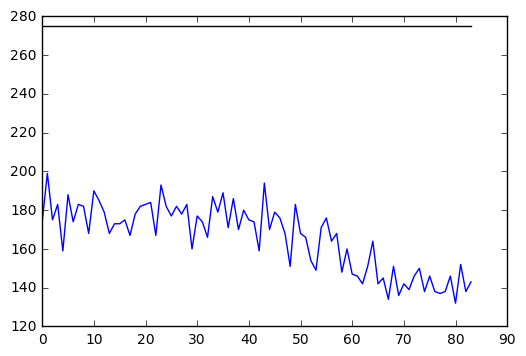

38


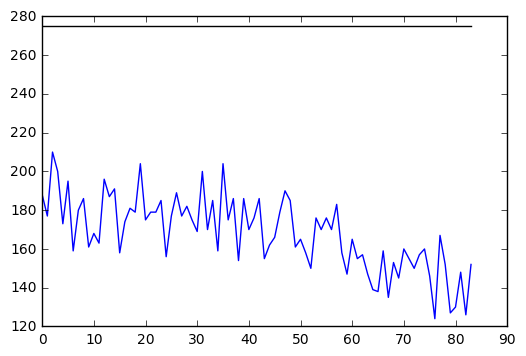

39


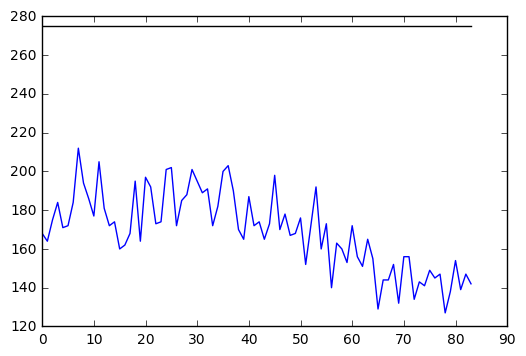

40


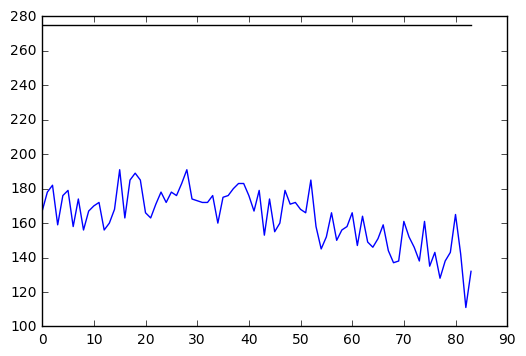

41


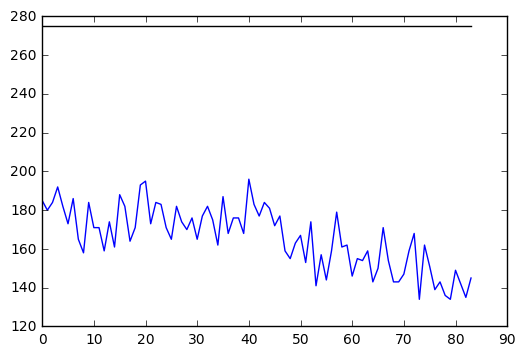

42


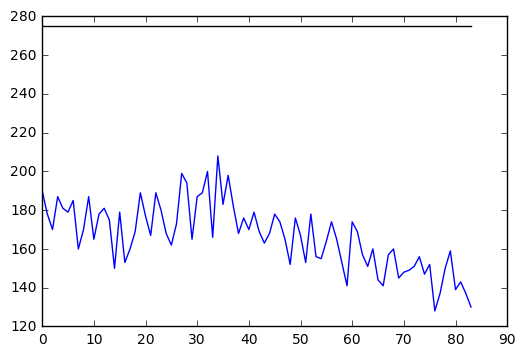

43


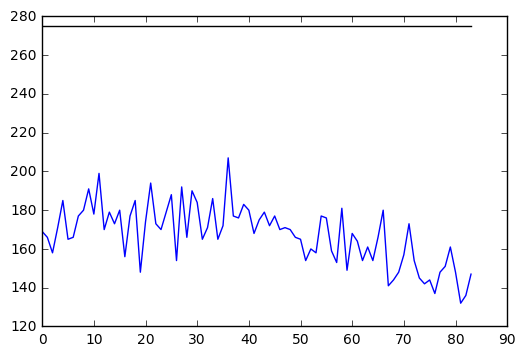

44


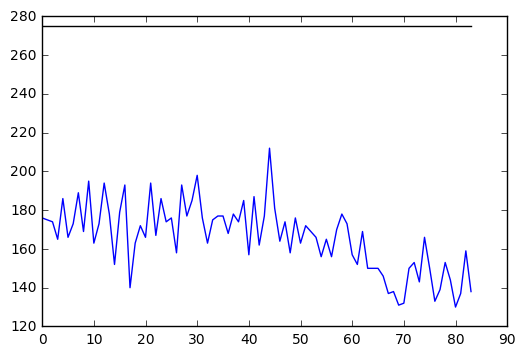

45


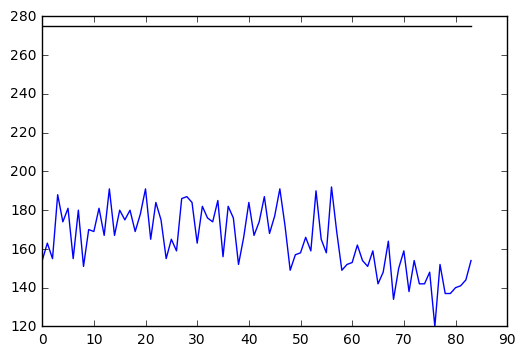

46


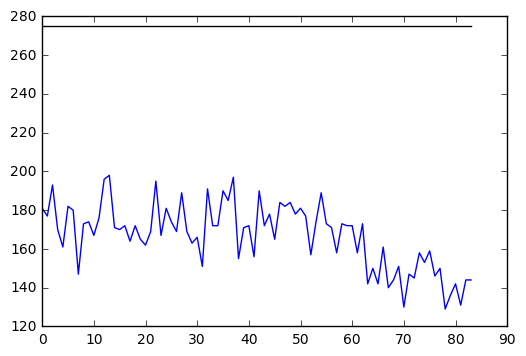

47


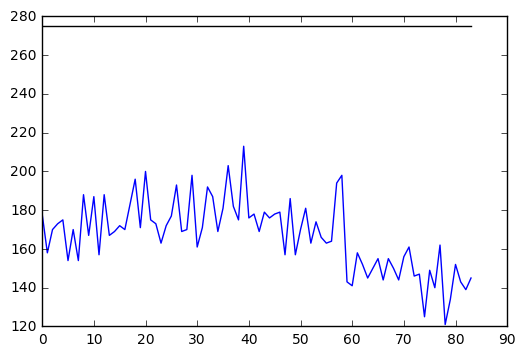

48


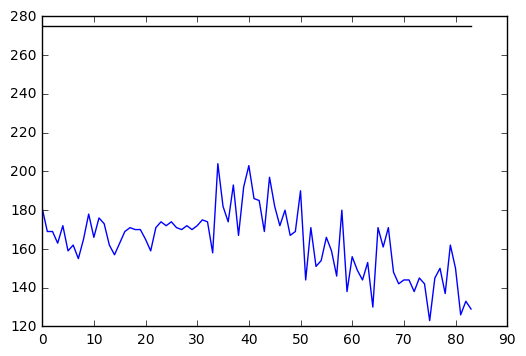

49


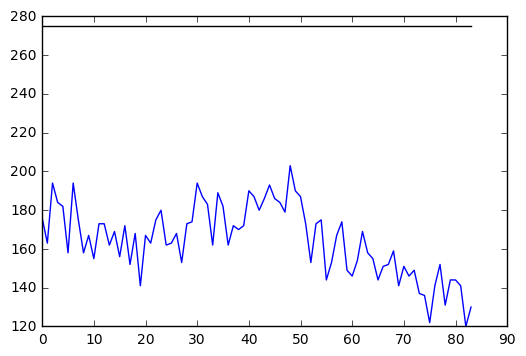

50


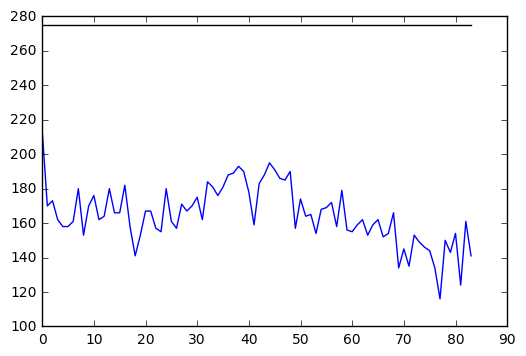

51


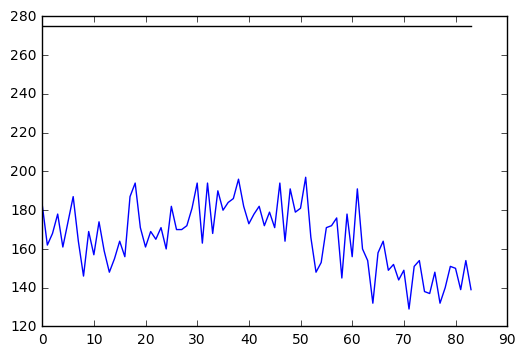

52


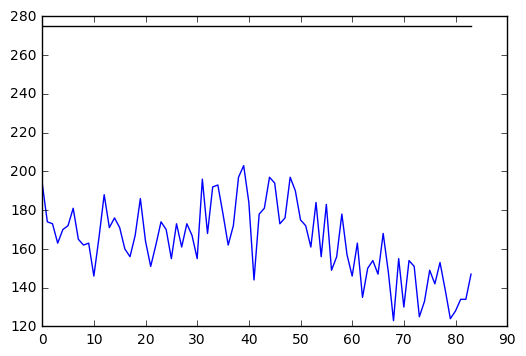

53


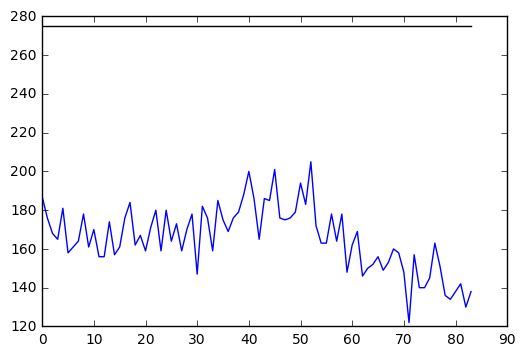

54


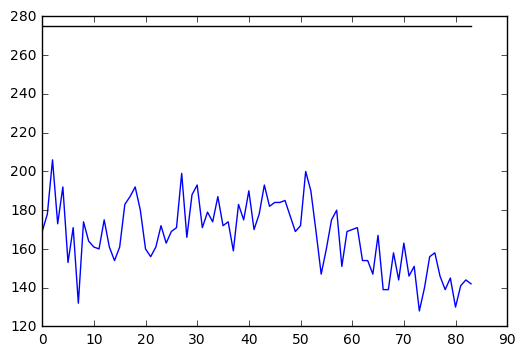

55


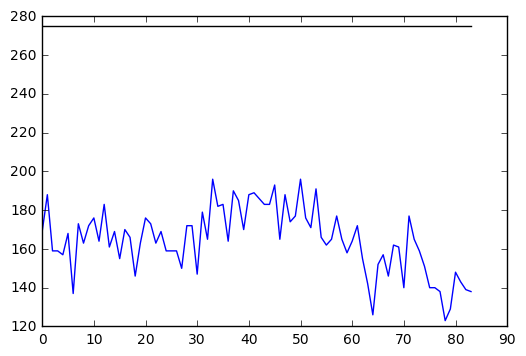

56


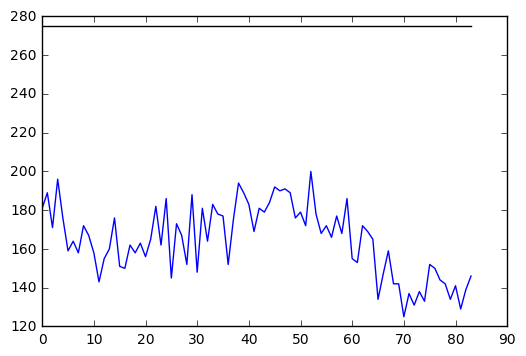

57


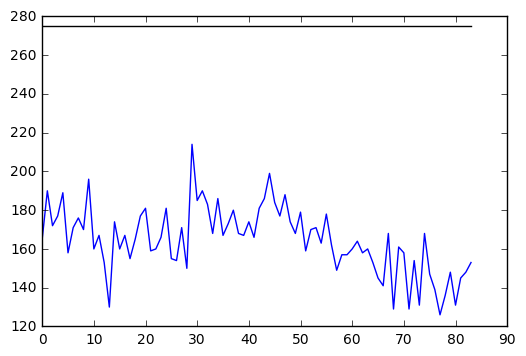

58


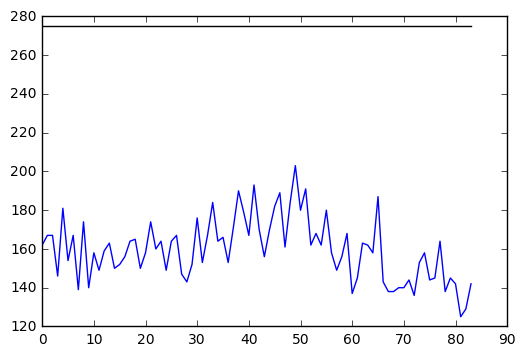

59


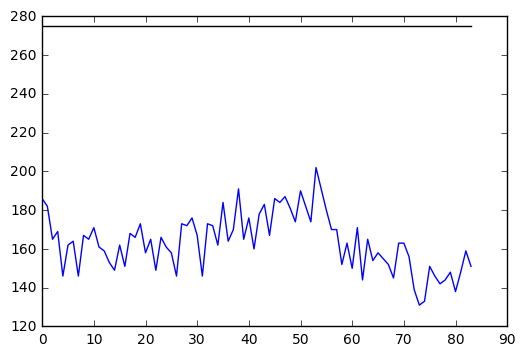

60


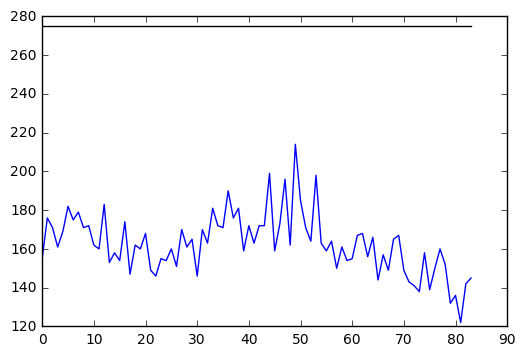

61


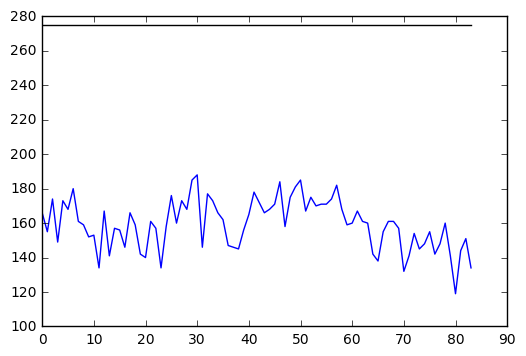

62


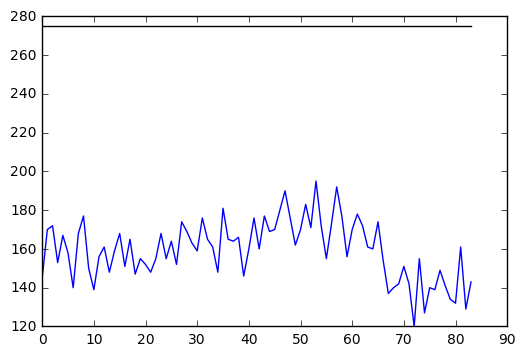

63


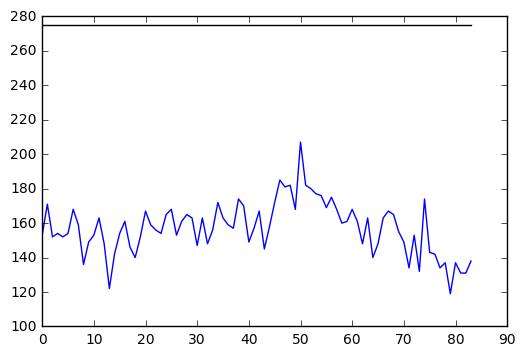

64


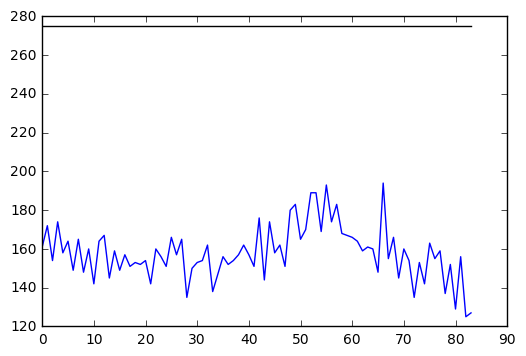

65


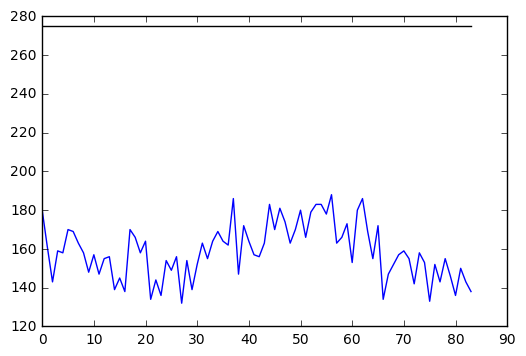

66


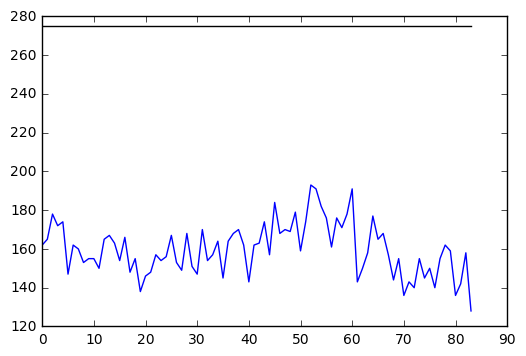

67


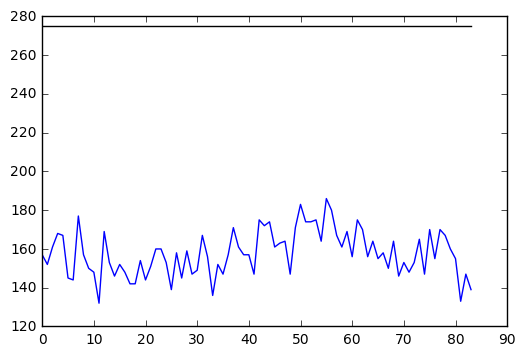

68


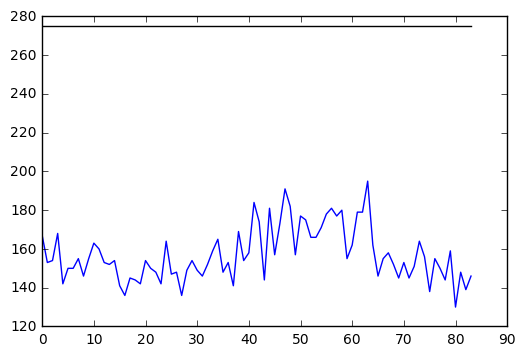

69


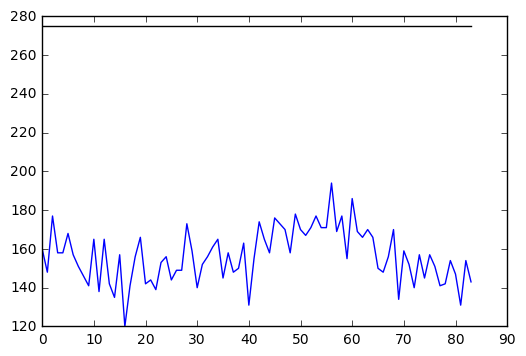

70


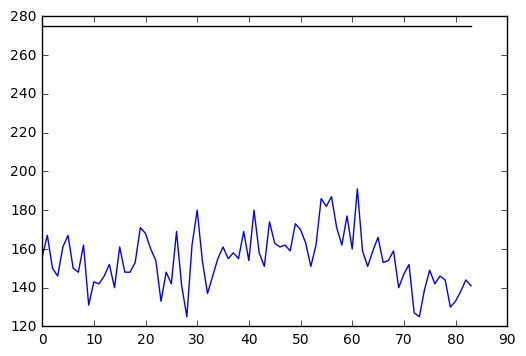

71


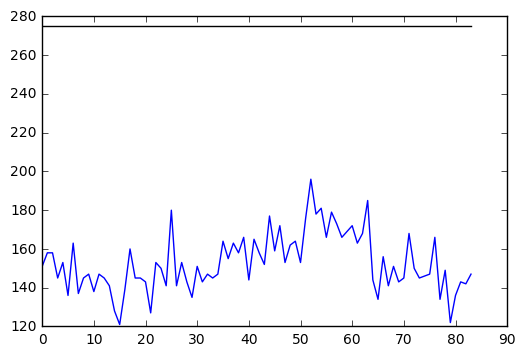

72


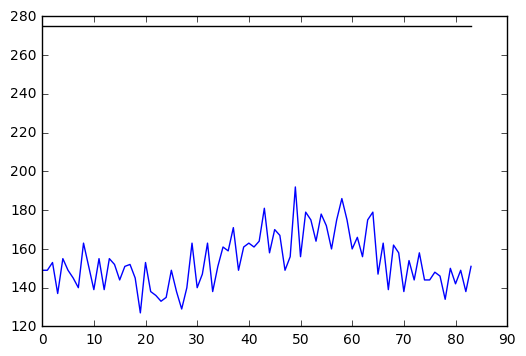

73


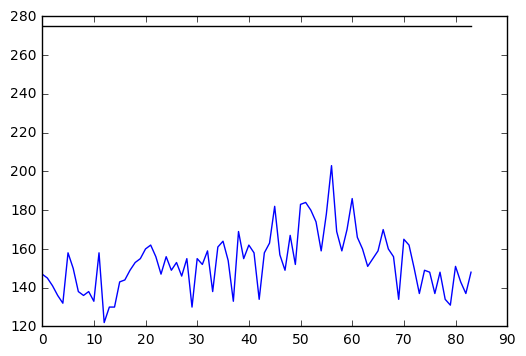

74


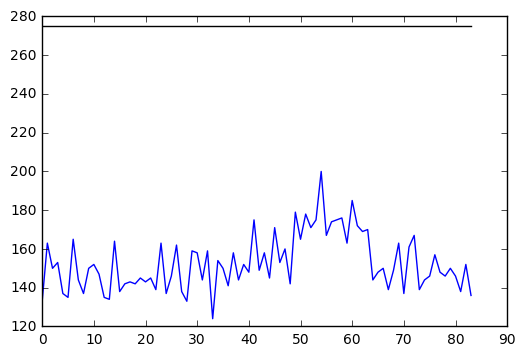

75


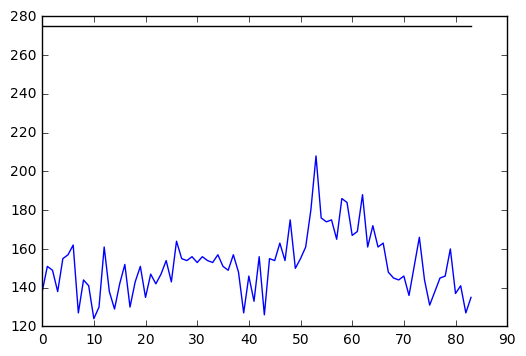

76


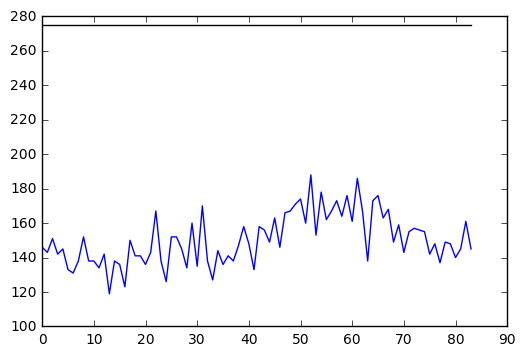

77


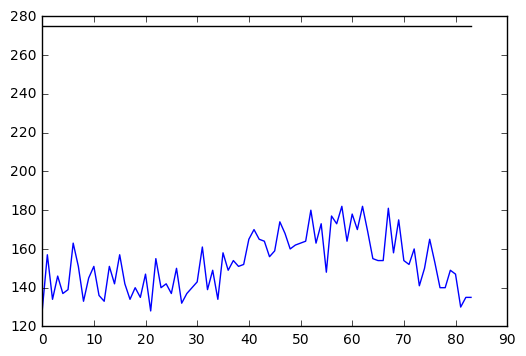

78


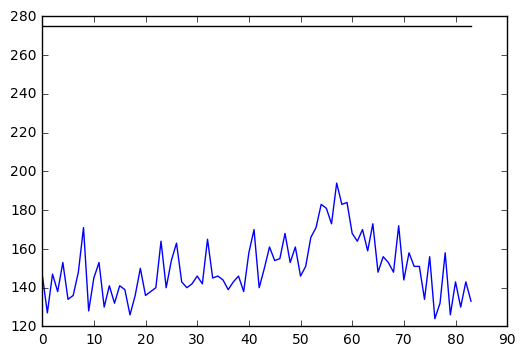

79


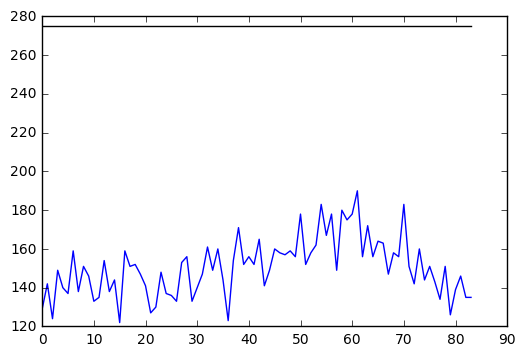

80


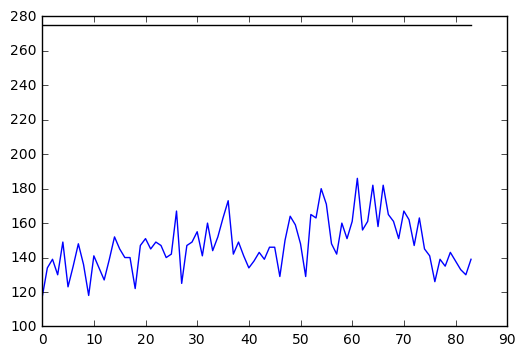

81


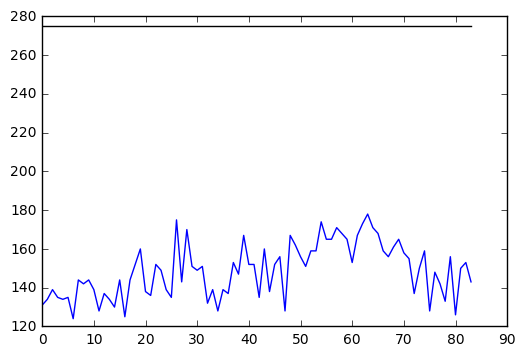

82


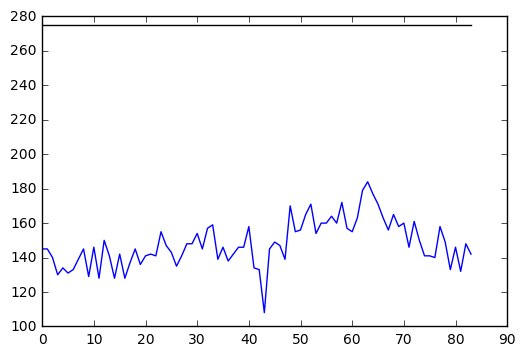

83


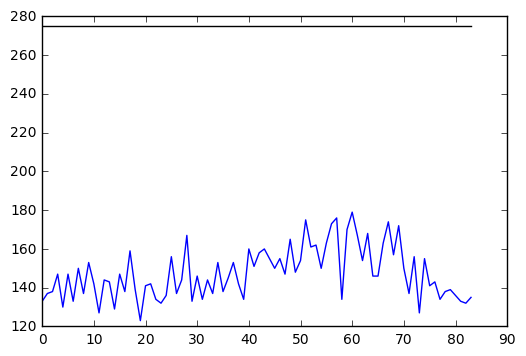

In [16]:
for line in range (imgarray.shape[1]):
    print (line)
    plt.plot(imgarray[line,:])
    plt.plot(np.array(range(0,(len(imgarray[0]))), int),np.linspace(275,275,imgarray.shape[1]), 'k')
    plt.show()